In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import KFold

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
# use GPU!
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cpu


In [70]:
# read data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X, y = torch.LongTensor(train.drop(['label'],axis=1).values), torch.tensor(train['label'].values)

training_size = 35000
X_train, y_train = X[:training_size].type(torch.LongTensor), y[:training_size].type(torch.LongTensor)
X_val, y_val = X[training_size:], y[training_size:]
X_test = torch.tensor(test.values)

X_train, y_train, X_val, y_val, X_test = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device), X_test.to(device)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([35000, 784])
torch.Size([7000, 784])
torch.Size([28000, 784])


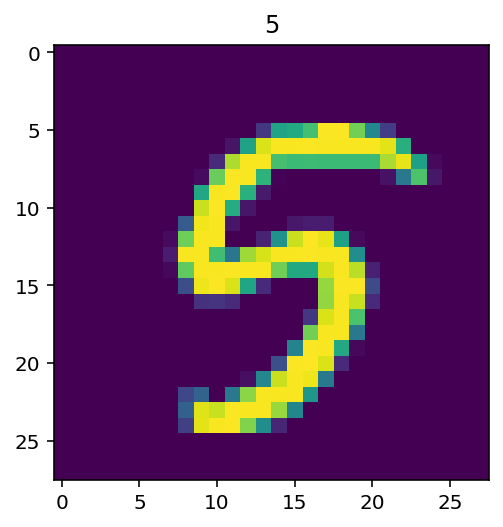

In [108]:
plt.imshow(X_train[8].reshape(28,28))
plt.title(y_train[8].item())
plt.show()

In [71]:
# make dataset and dataloader
dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_val, y_val)

batch_size = 50
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [72]:
# build a CNN!
class mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [73]:
# loss function 
loss_function = F.cross_entropy

# instantiate model
model = mnist_CNN().to(device)

# optimizer for updating weights
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [78]:
loss_function(model(X.type(torch.LongTensor)), y_train.type(torch.LongTensor))

RuntimeError: expected scalar type Long but found Float

In [77]:
y_train.type(torch.LongTensor)

tensor([1, 0, 1,  ..., 7, 7, 0])

In [ ]:
# let's train
n_epochs = 30
train_loss = []
val_loss = []
iteration = []
for epoch in range(n_epochs):
    iteration.append(epoch)
    
    model.train()
    for xb, yb in dataloader_train:
        xb = xb.to(device)
        yb = yb.to(device)
        
        pred = model(xb)
        loss = loss_function(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
        train_loss.append(loss_function(model(X_train), y_train))